### DWT-MRA(1D)를 input으로 넣고 1D를 output으로 출력하는 모델 -> MRA level을 feature로 봄
#### Contaminated, Clean Scale을 다르게 함. (각자 scaling)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pywt

import sys
sys.path.append('../../../tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
from DataPlot import Data_Load_Plot, Result_Plot, Train_Loss_Plot

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


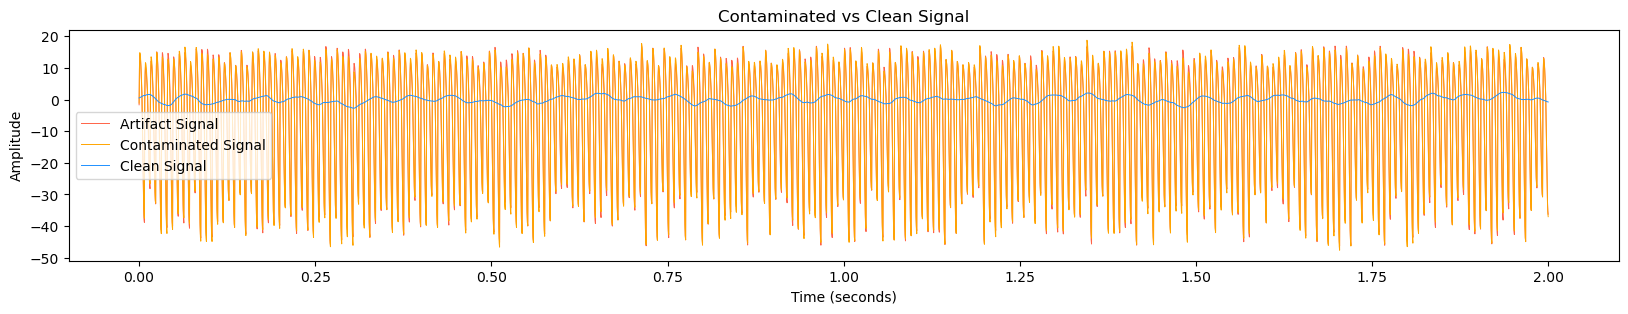

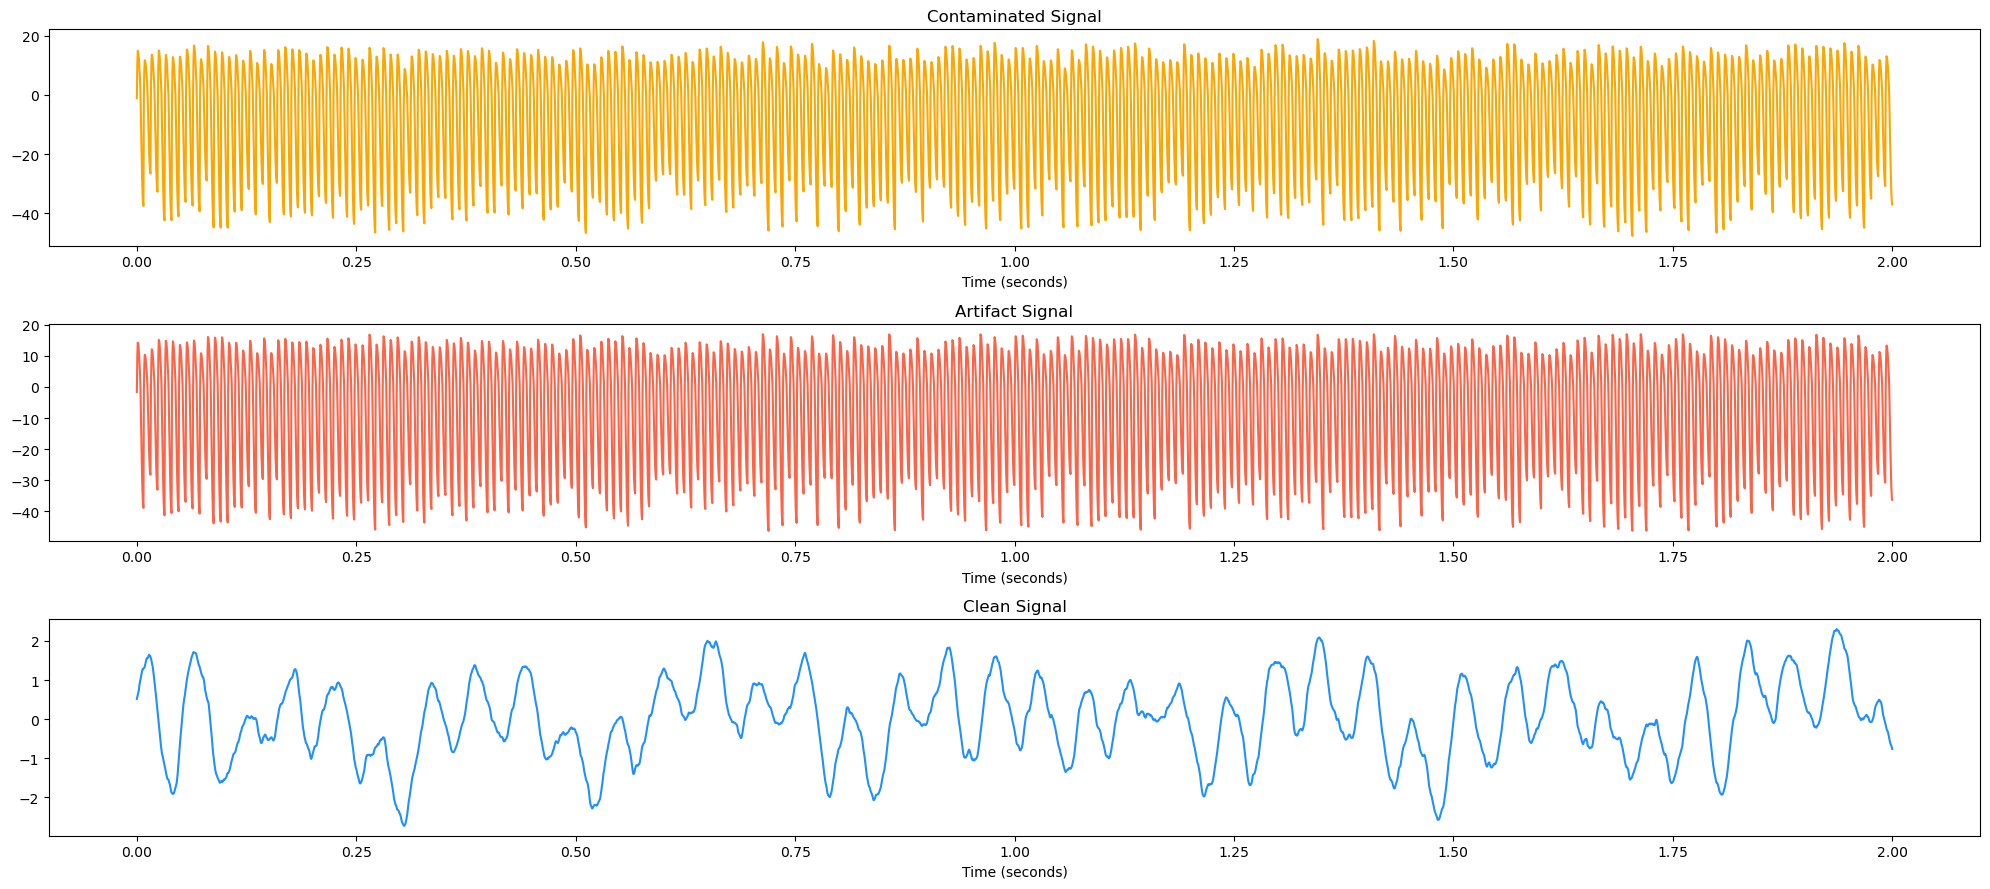

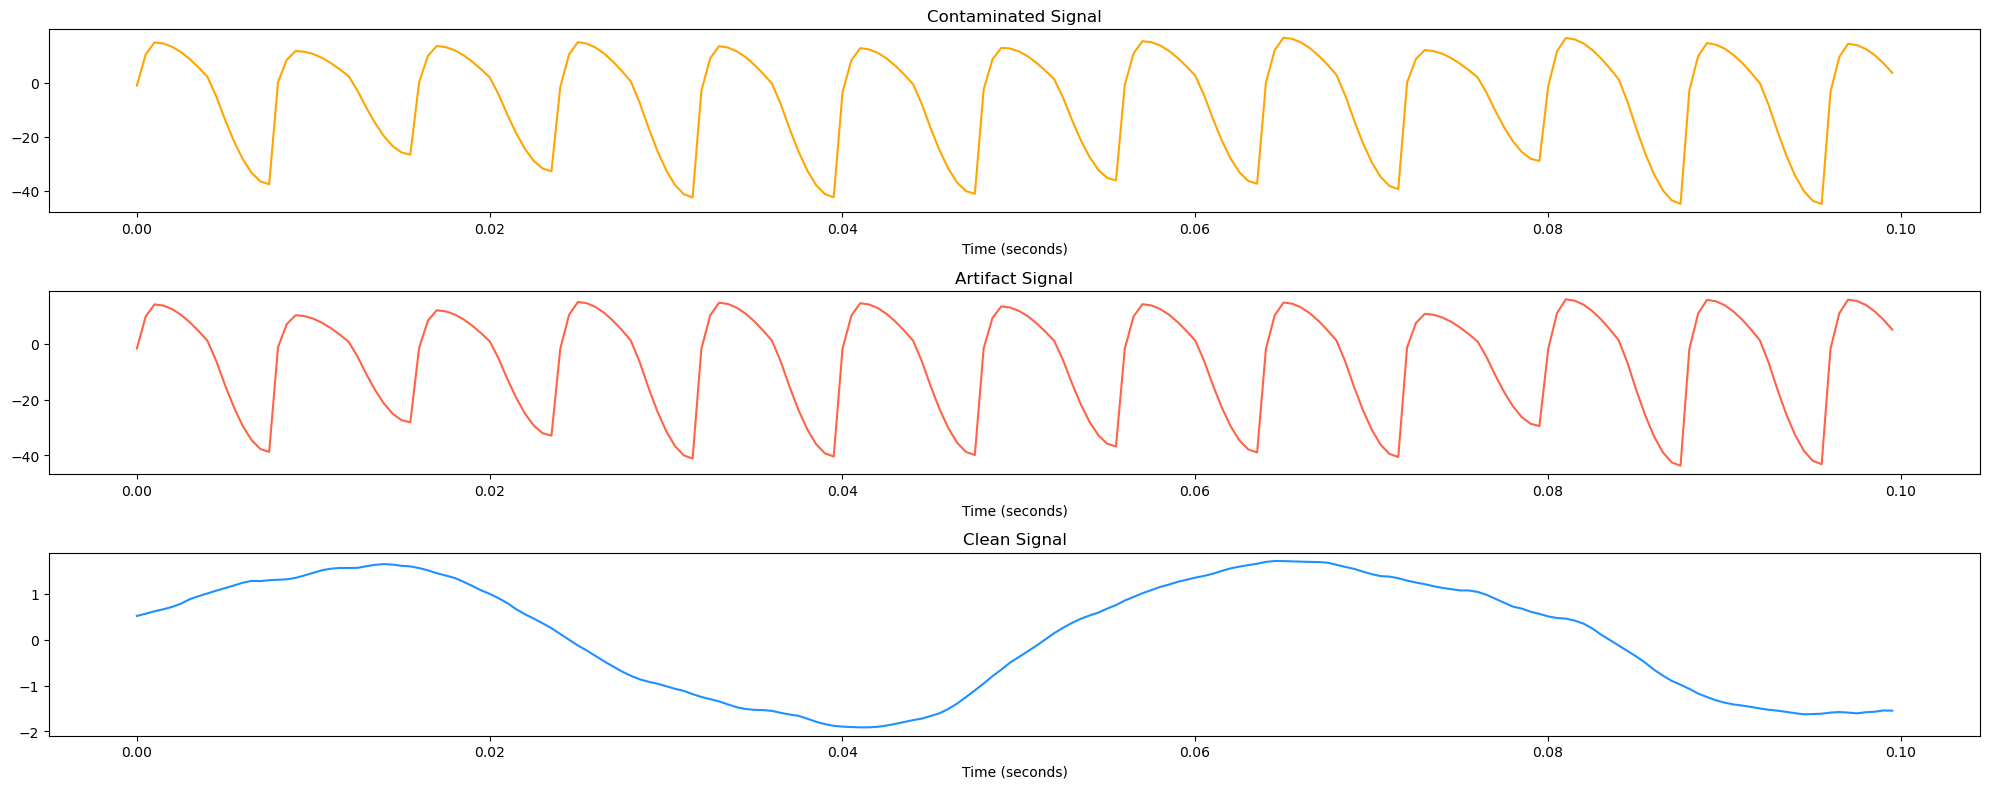

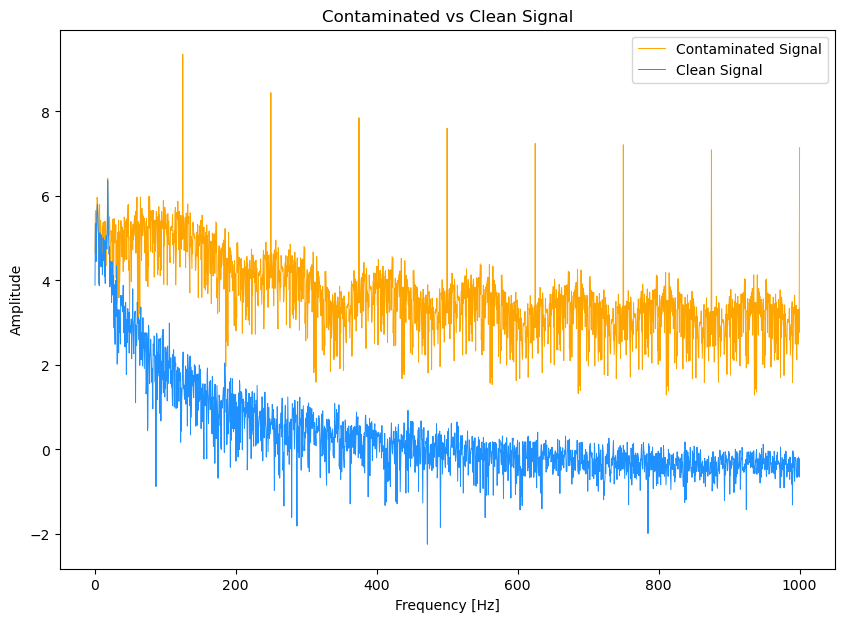

In [2]:
# 데이터 load & plot
datapath='../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

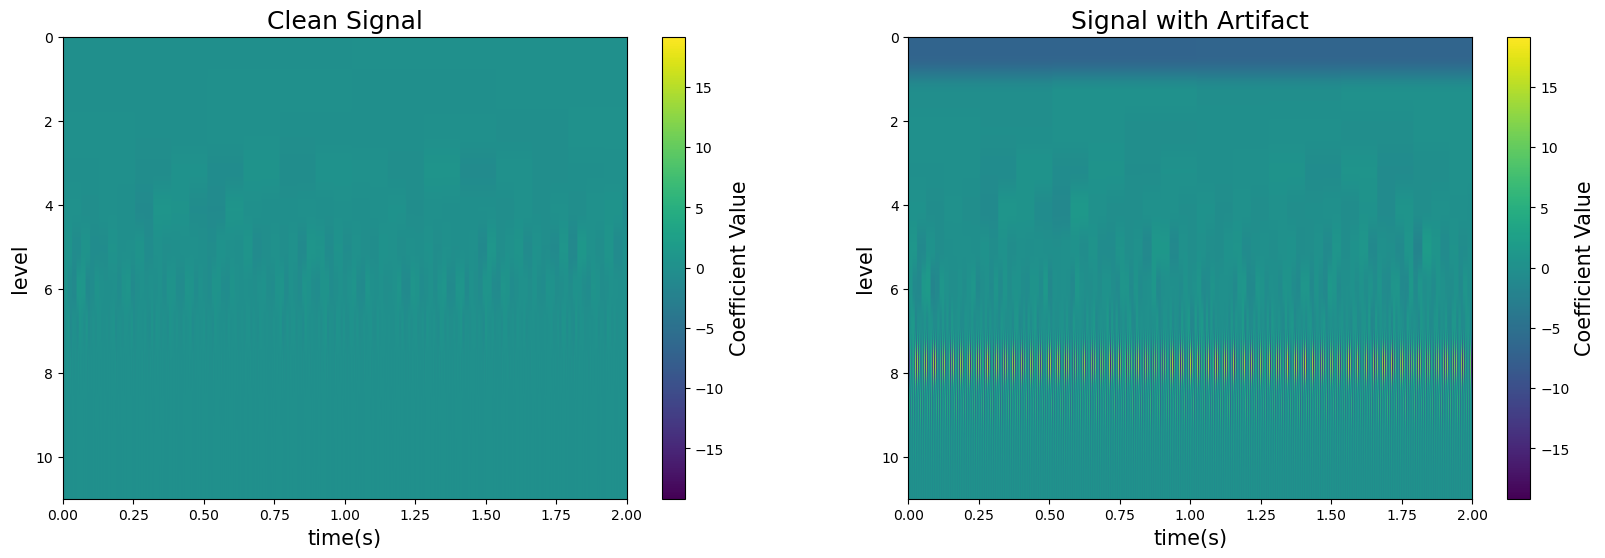

In [3]:
# DWT 수행 (MRA)
wavelet = 'db1'
mra_sig = pywt.mra(Clean_data[0], wavelet, transform='dwt')
mra_art = pywt.mra(Contaminated_data[0], wavelet, transform='dwt')

mra_sig = np.array(mra_sig)
mra_art = np.array(mra_art)

vmin, vmax = min(mra_sig.min(), mra_art.min()), max(mra_sig.max(), mra_art.max())

t = np.linspace(0, 2, num=4000)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.imshow(mra_sig, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Clean Signal', fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(mra_art, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Signal with Artifact', fontsize=18)

plt.show()

In [4]:
X_wt = []
y_wt = []

wavelet = 'db1'

for x, y in zip(Contaminated_data, Clean_data):
    mra_x = pywt.mra(x, wavelet, transform='dwt')
    mra_y = pywt.mra(y, wavelet, transform='dwt')
    X_wt.append(mra_x)
    y_wt.append(mra_y)

X_wt = np.array(X_wt)
y_wt = np.array(y_wt)

print("X_wt:", X_wt.shape)
print("y_wt:", y_wt.shape)

X_wt: (1000, 12, 4000)
y_wt: (1000, 12, 4000)


In [5]:
# MRA 결과 scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = []
y = [] 

scaler_x.fit(X_wt[0].flatten().reshape(-1, 1))
scaler_y.fit(y_wt[0].flatten().reshape(-1, 1))

for xx, yy in zip(X_wt, y_wt):
    flat_x = xx.flatten().reshape(-1, 1)
    flat_y = yy.flatten().reshape(-1, 1)
    scaled_flat_x = scaler_x.transform(flat_x)
    scaled_flat_y = scaler_y.transform(flat_y) # X, y 각자 scaling
    X.append(scaled_flat_x.reshape(xx.shape))
    y.append(scaled_flat_y.reshape(yy.shape))

X = np.transpose(np.array(X), (0, 2, 1))
y = np.transpose(np.array(y), (0, 2, 1))

print("X:", X.shape)
print("y:", y.shape)

X: (1000, 4000, 12)
y: (1000, 4000, 12)


In [6]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Data Shape>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Data Shape>
-----------------------------
X_train shape: (800, 4000, 12)
y_train shape: (800, 4000, 12)
-----------------------------
X_test shape: (200, 4000, 12)
y_test shape: (200, 4000, 12)
-----------------------------


In [7]:
# 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=12, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=12)
        self.drop = nn.Dropout(0.25)
        self.gelu = nn.GELU()

    def forward(self, input_data): # x : B x T x 1
        x = self.gelu(self.fc1(input_data)) # x : B x T x 256
        x = self.drop(x)
        x = self.gelu(self.fc2(x)) # x : B x T x 128
        x = self.drop(x)
        x = self.gelu(self.fc3(x)) # x : B x T x 64
        x = self.drop(x)
        x = self.fc4(x) # x : B x T x 1 -> x : B x T
        return x

model = MLP().to(device)
print(model)

MLP(
  (fc1): Linear(in_features=12, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=12, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (gelu): GELU(approximate='none')
)


In [8]:
num_samples = 4000
height = 12
width = 2000

model = MLP().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

MLP(
  (fc1): Linear(in_features=12, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=12, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (gelu): GELU(approximate='none')
)


In [9]:
# 모델 학습
num_epochs = 1000

loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_list.append(epoch_loss)
    if (epoch+1)%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss}')

Epoch [1/1000] | Loss: 1.0099804997444153
Epoch [2/1000] | Loss: 0.883211703300476
Epoch [3/1000] | Loss: 0.7289455389976501
Epoch [4/1000] | Loss: 0.6210408997535706
Epoch [5/1000] | Loss: 0.5474390840530395
Epoch [6/1000] | Loss: 0.5067154753208161
Epoch [7/1000] | Loss: 0.486273764371872
Epoch [8/1000] | Loss: 0.47260515332221986
Epoch [9/1000] | Loss: 0.4576486647129059
Epoch [10/1000] | Loss: 0.4461030101776123
Epoch [11/1000] | Loss: 0.44102584838867187
Epoch [12/1000] | Loss: 0.43827022552490236
Epoch [13/1000] | Loss: 0.4363436436653137
Epoch [14/1000] | Loss: 0.4349374091625214
Epoch [15/1000] | Loss: 0.4337009835243225
Epoch [16/1000] | Loss: 0.43285404443740844
Epoch [17/1000] | Loss: 0.4319238495826721
Epoch [18/1000] | Loss: 0.4310723662376404
Epoch [19/1000] | Loss: 0.4302422094345093
Epoch [20/1000] | Loss: 0.42922998666763307
Epoch [21/1000] | Loss: 0.4278639554977417
Epoch [22/1000] | Loss: 0.42509608387947084
Epoch [23/1000] | Loss: 0.41987775564193724
Epoch [24/1000]

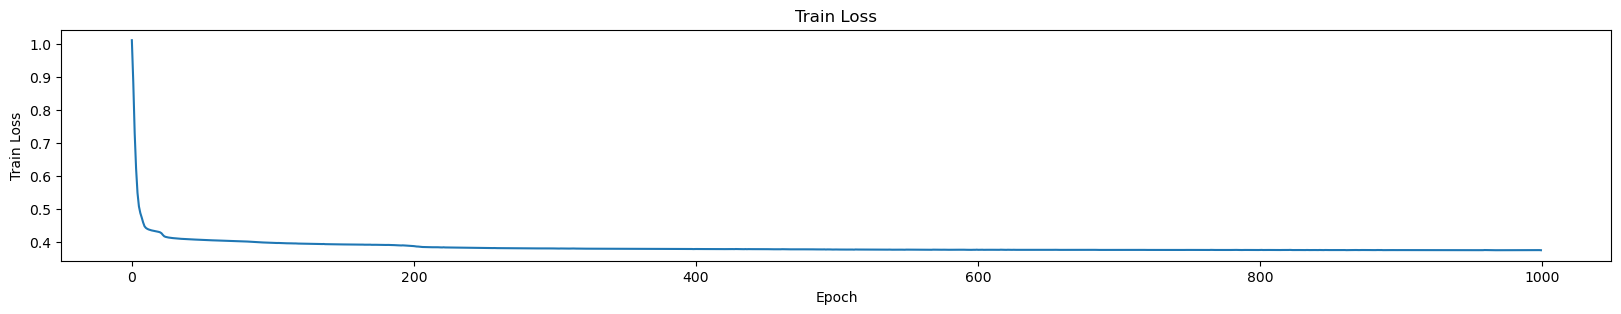

Minimal Train Loss: 0.3736299359798431 [999]



In [10]:
Train_Loss_Plot(loss_list)

In [11]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
test_loss = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        test_loss += loss.item() * x.size(0)

        Contaminated = torch.cat((Contaminated, x.permute(0, 2, 1).cpu()), 0)
        SACed = torch.cat((SACed, y_pred.permute(0, 2, 1).cpu()), 0)
        Clean = torch.cat((Clean, y.permute(0, 2, 1).cpu()), 0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

print(Contaminated.shape)

Test Loss: 0.3284
torch.Size([200, 12, 4000])


Mean Absolute Error: 0.37925222516059875
Mean Squared Error: 0.2996092140674591


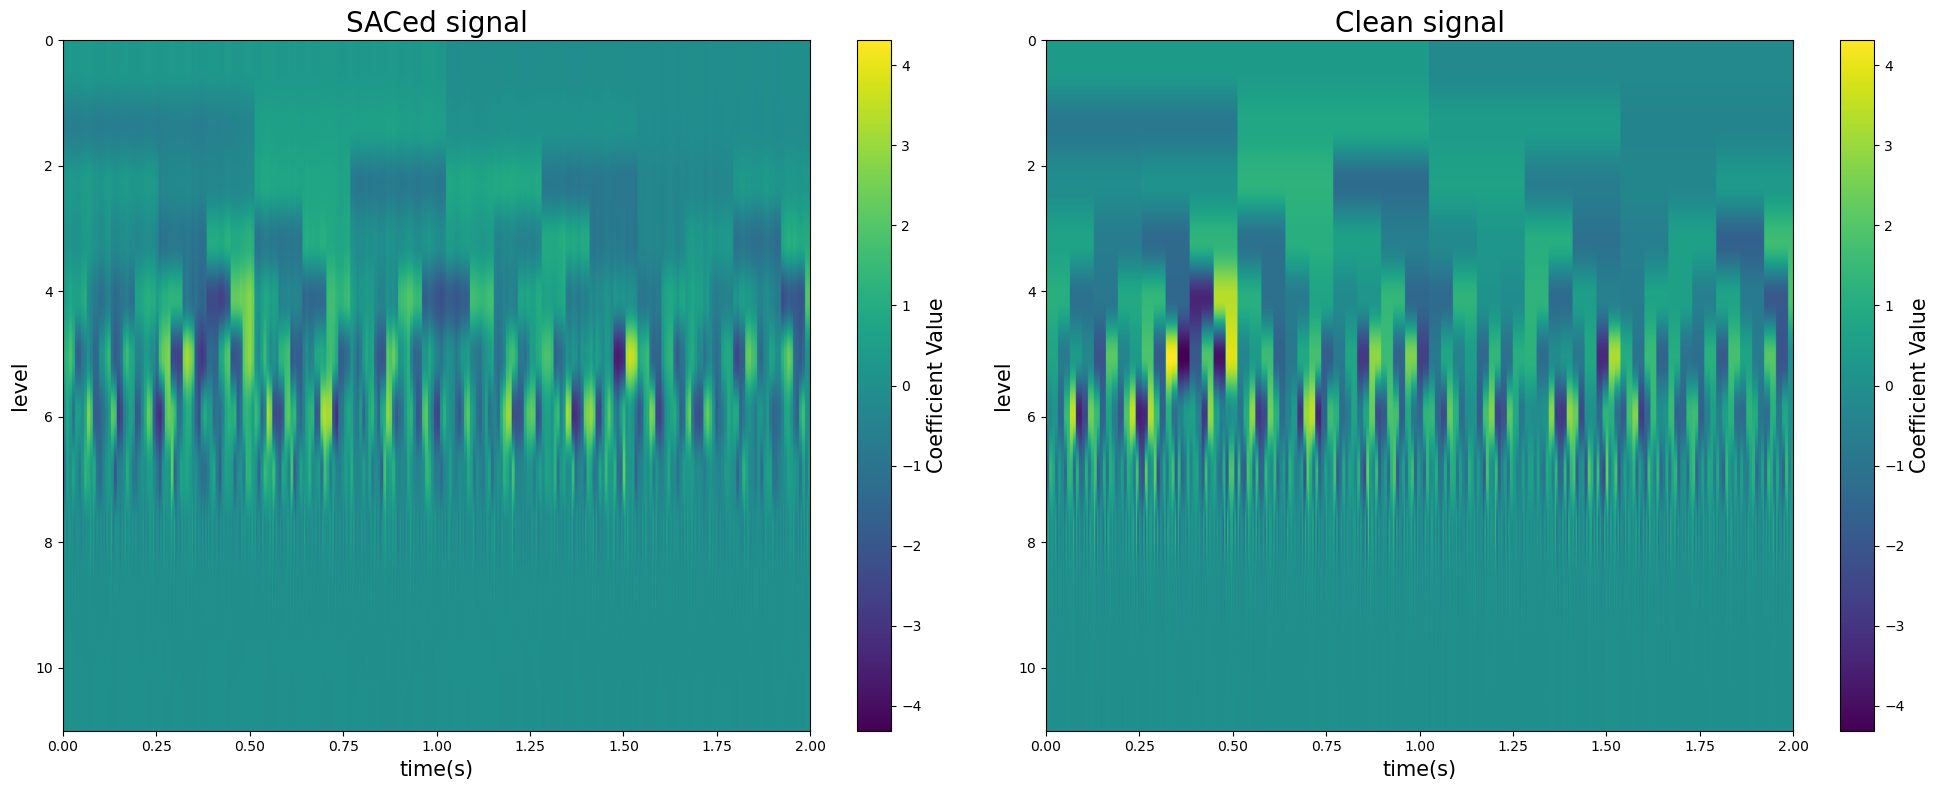

In [12]:
# MRA Plot
SACed_ex = SACed[0].detach().cpu()
Clean_ex = Clean[0].detach().cpu()

vmin, vmax = min(SACed_ex.min(), Clean_ex.min()), max(SACed_ex.max(), Clean_ex.max())

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(SACed_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('SACed signal', fontsize=20)

plt.subplot(1, 2, 2)
plt.imshow(Clean_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Clean signal', fontsize=20)

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_ex, SACed_ex)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_ex, SACed_ex)}")

<Time Domain Error>
Mean Absolute Error: 0.13908030747297823
Mean Squared Error: 0.03665468635535427


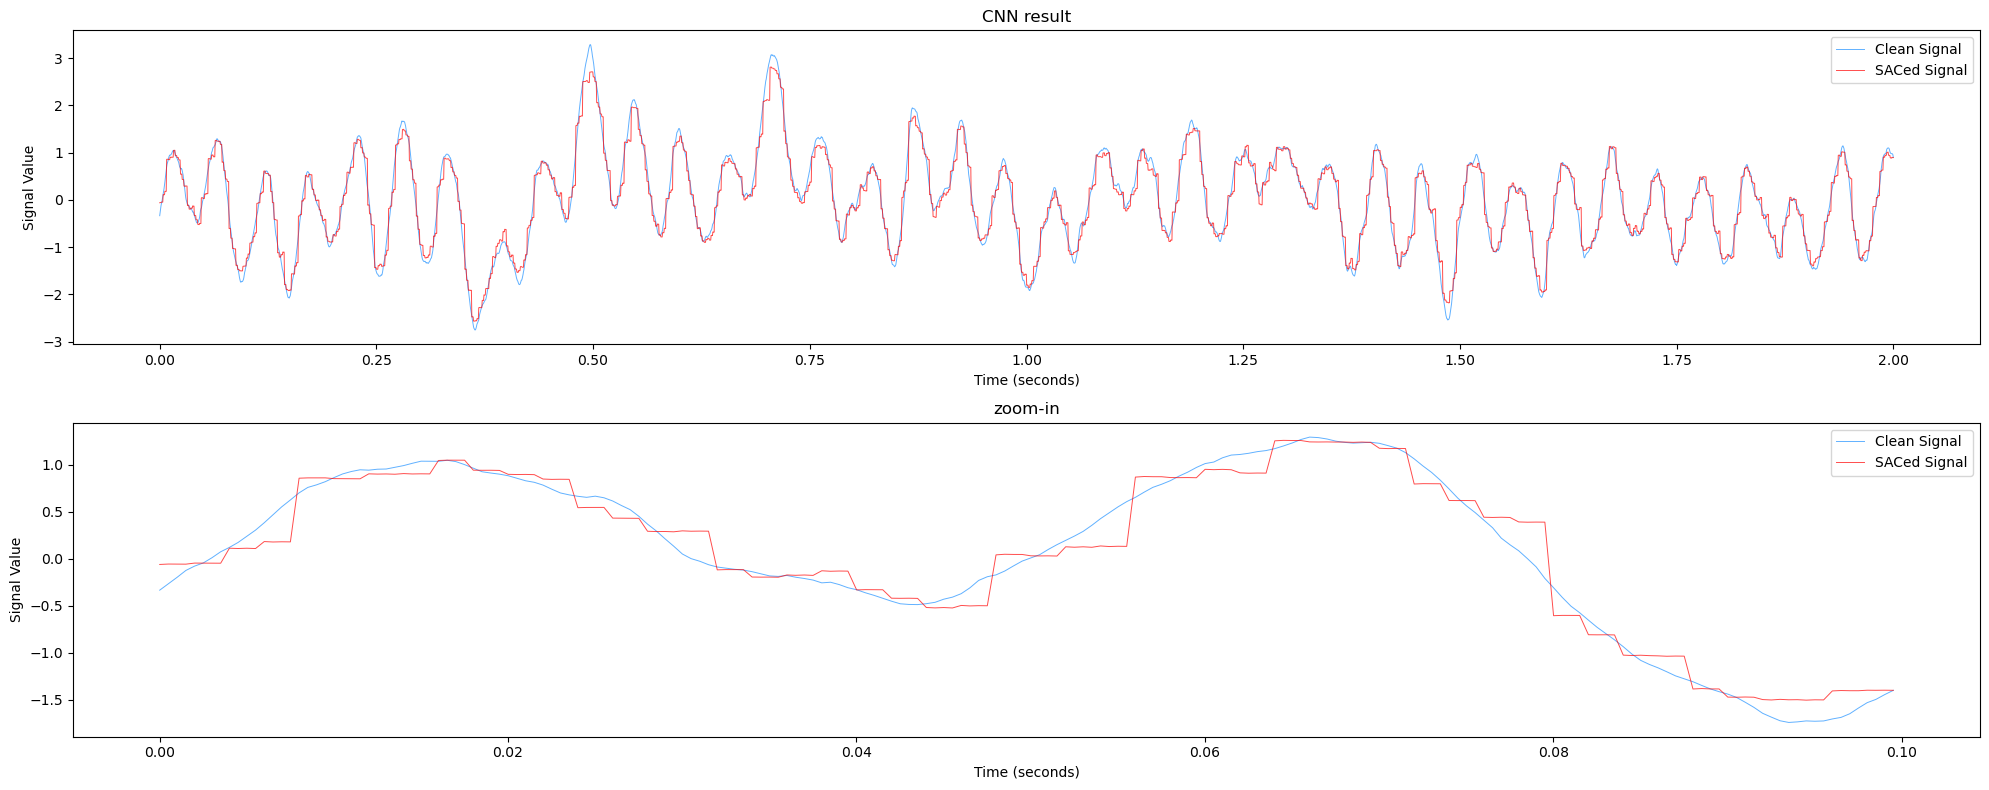

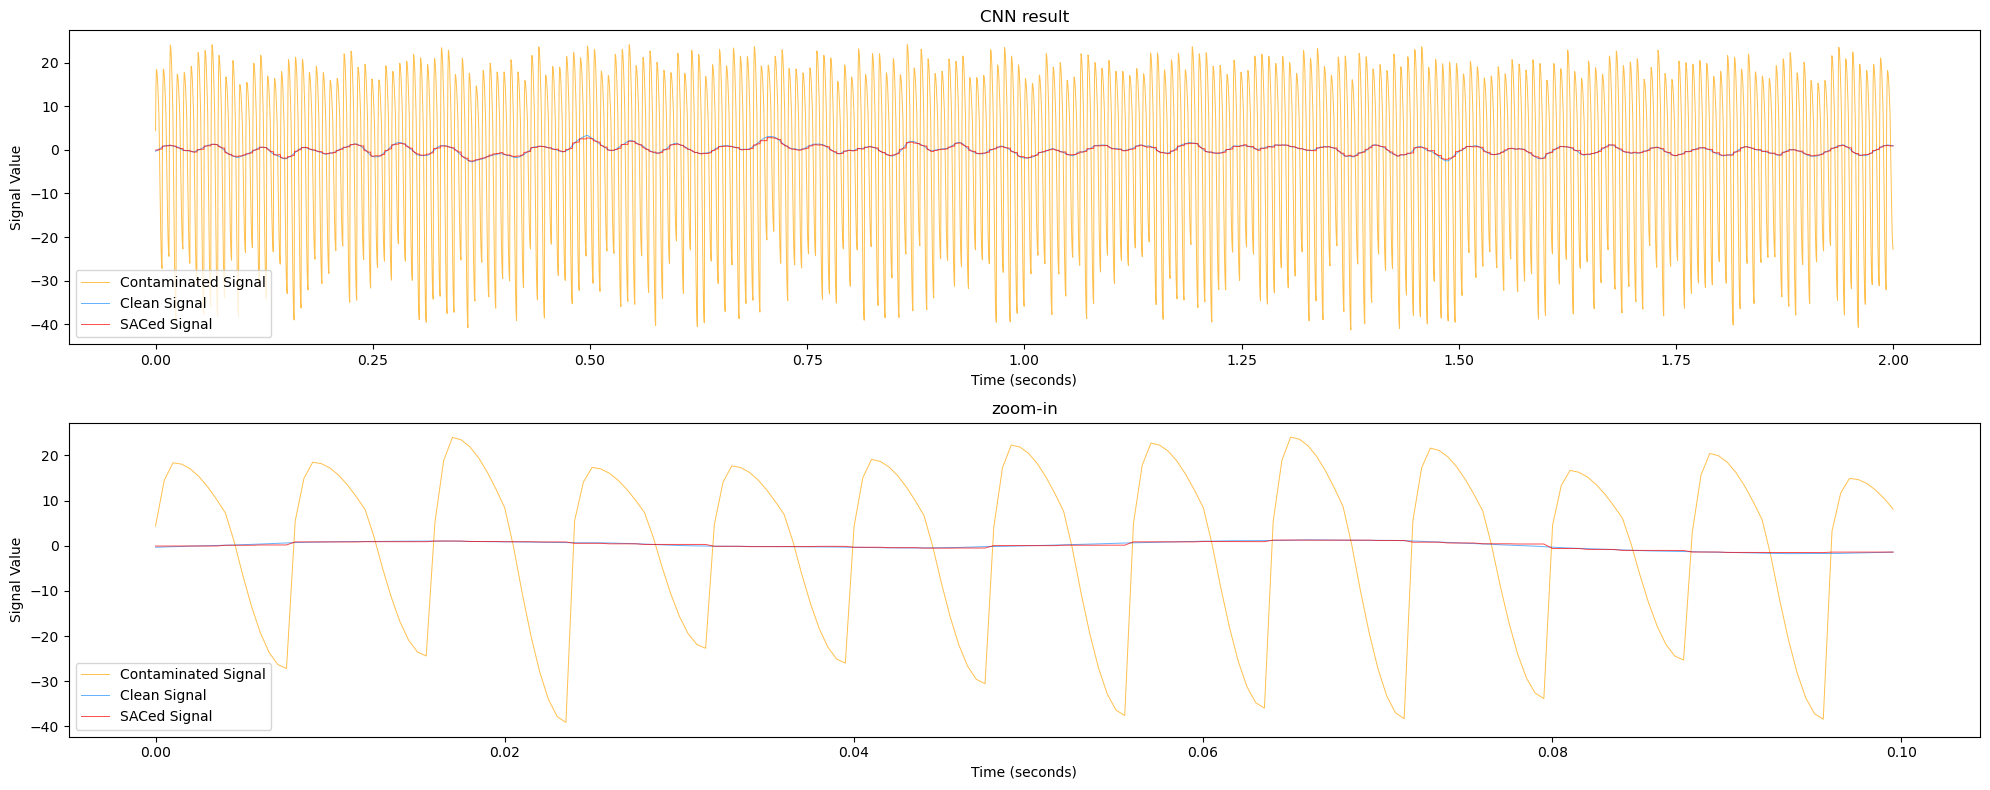

<Frequency Domain Error>
Mean Absolute Error: 1.1227812807484574
Mean Squared Error: 1.9883988109871438


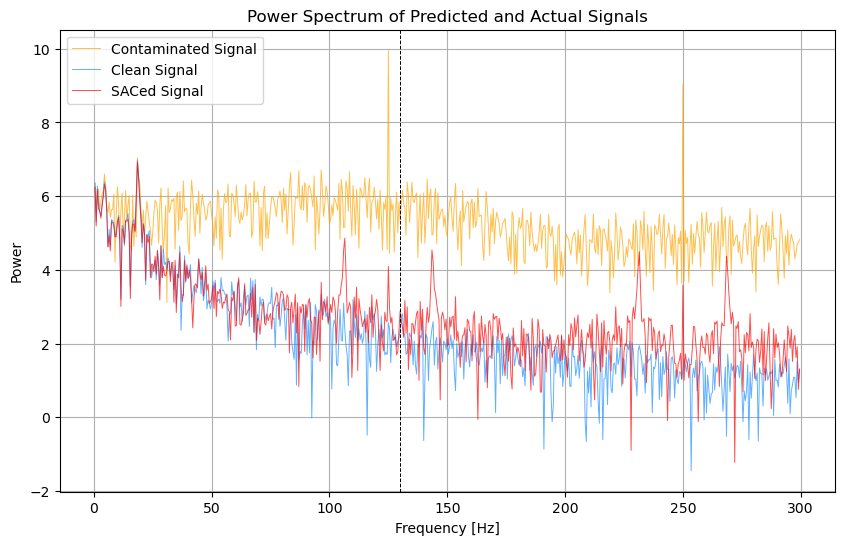

In [13]:
# inverse scaling
Contaminated_inverse_scaled = np.array([scaler_x.inverse_transform(pywt.imra(Contaminated[0]).reshape(-1, 1)).squeeze()])
SACed_inverse_scaled = np.array([scaler_x.inverse_transform(pywt.imra(Contaminated[0]).reshape(-1, 1)).squeeze()])
Clean_inverse_scaled = np.array([scaler_x.inverse_transform(pywt.imra(Contaminated[0]).reshape(-1, 1)).squeeze()])

for x, y_pred, y in zip(Contaminated, SACed, Clean):
    x_inversed = scaler_x.inverse_transform(pywt.imra(x).reshape(-1, 1)).squeeze()
    y_pred_inversed = scaler_y.inverse_transform(pywt.imra(y_pred).reshape(-1, 1)).squeeze()
    y_inversed = scaler_y.inverse_transform(pywt.imra(y).reshape(-1, 1)).squeeze()
    
    Contaminated_inverse_scaled = np.vstack((Contaminated_inverse_scaled, x_inversed))
    SACed_inverse_scaled = np.vstack((SACed_inverse_scaled, y_pred_inversed))
    Clean_inverse_scaled = np.vstack((Clean_inverse_scaled, y_inversed))

Contaminated_inverse_scaled = np.delete(Contaminated_inverse_scaled, 0, axis=0)
SACed_inverse_scaled = np.delete(SACed_inverse_scaled, 0, axis=0)
Clean_inverse_scaled = np.delete(Clean_inverse_scaled, 0, axis=0)

# 결과 Plot
Result_Plot(Contaminated_inverse_scaled, SACed_inverse_scaled, Clean_inverse_scaled) # inverse scaled data를 input으로 넣음